<a href="https://colab.research.google.com/github/MHX1203/DataWhale-DataMining/blob/master/Model_Construction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import os
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 200)
sns.set_style('white')
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
import pandas_profiling
pd.set_option('mode.chained_assignment', None)
%matplotlib inline

In [2]:
train_data = pd.read_csv('/content/drive/My Drive/Data/used_car_train_20200313.csv', sep=' ')
test_data = pd.read_csv('/content/drive/My Drive/Data/used_car_testA_20200313.csv', sep=' ')
train_data.shape, test_data.shape

((150000, 31), (50000, 30))

In [0]:
# price = train
train_data['price'] = np.log1p(train_data['price'])

train_data = train_data.dropna(subset=['model'])

train_data = train_data[train_data['power'] <= 600]



In [4]:
price = train_data.price
del train_data['price']
data = pd.concat([train_data, test_data], axis=0)
data.shape

(199856, 30)

In [5]:
"""

bodyType, fuelType和gearbox直接填充众数
"""
data.loc[data['bodyType'].isnull(), 'bodyType'] = data['bodyType'].mode()[0]
print('after handle missing, null value counts in %s: %d'%('bodyType', data['bodyType'].isnull().sum()))

data.loc[data['fuelType'].isnull(), 'fuelType'] = data['fuelType'].mode()[0]
print('after handle missing, null value counts in %s: %d'%('fuelType', data['fuelType'].isnull().sum()))

data.loc[data['gearbox'].isnull(), 'gearbox'] = data['gearbox'].mode()[0]
print('after handle missing, null value counts in %s: %d'%('gearbox', data['gearbox'].isnull().sum()))

data['notRepairedDamage'] = data['notRepairedDamage'].apply(lambda x: float(x) if x != '-' else 2.0)

group_bodyType = data[data['power'] > 0].groupby('bodyType', axis=0).agg('median').reset_index()
group_bodyType = group_bodyType.set_index('bodyType')



data.power = data.apply(lambda x: x.power if x.power != 0 else group_bodyType.loc[x.bodyType].power, axis=1)

data['reg_year'] = data['regDate'].map(lambda x: int(str(x)[:4]))

data['create_year'] = data['creatDate'].map(lambda x: int(str(x)[:4]))

data['delta_year'] = data['create_year'] - data['reg_year']
data['delta_year'] = data['delta_year'].apply(lambda x: 3 if (x // 5) >3 else x // 5)

after handle missing, null value counts in bodyType: 0
after handle missing, null value counts in fuelType: 0
after handle missing, null value counts in gearbox: 0


In [0]:
digit_feats =[col for col in data.columns if col.startswith('v_')]

skews = data[digit_feats].skew().sort_values()
skew_idx = skews[np.abs(skews) > 0.5].index


# 对于存在小于0的特征，先取指数(这里数值较小)，再进行box-cox处理
exp_boxcoxs = ['v_14', 'v_11', 'v_2']
for col in exp_boxcoxs:
  # train_data[col] = np.log1p(train_data[col])
  data[col] = boxcox1p(np.exp(data[col]), boxcox_normmax(np.exp(data[col]) + 1))

for col in skew_idx:
  if col not in exp_boxcoxs:
    data[col] = boxcox1p(data[col], boxcox_normmax(data[col] + 1))

(149856, 33)

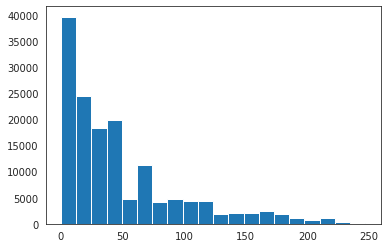

In [7]:

plt.hist(train_data['model'], bins=20)
plt.show()

In [12]:
len(np.unique(train_data['model']))

248

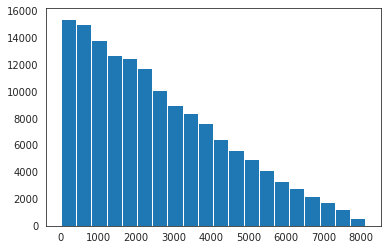

In [8]:
plt.hist(train_data['regionCode'], bins=20)
plt.show()

In [10]:
len(np.unique(train_data['regionCode']))

7904

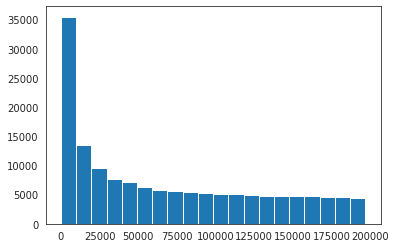

In [9]:
plt.hist(train_data['name'], bins=20)
plt.show()

In [11]:
len(np.unique(train_data['name']))

99537

In [13]:
# 猜想相邻区域的编、汽车交易名称、汽车品牌应该具有较小的差异
bining_feats = ['regionCode', 'model', 'name']
data[bining_feats].info()

for col in bining_feats:
  # a = data[col].astype('float64')
  bins = [np.percentile(data[col], i * 10) for i in range(11)]
  # labels = range(10)
  data[col] = pd.cut(data[col], bins=bins, labels=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199856 entries, 0 to 49999
Data columns (total 3 columns):
regionCode    199856 non-null int64
model         199856 non-null float64
name          199856 non-null int64
dtypes: float64(1), int64(2)
memory usage: 6.1 MB


In [14]:
train_data = data[:len(train_data)]
train_data.shape

(149856, 33)

In [15]:
data.head(10)

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,regionCode,seller,offerType,creatDate,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,reg_year,create_year,delta_year
0,0,0.0,20040402,4.0,6,1.0,0.0,0.0,60.0,12.5,0.0,2.0,0,0,20160404,1.659918e+09,3.966344,0.439570,2.159744,1.143786,35.025022,0.101988,0.079531,0.022816,0.097462,-2.881803,1.245177,-2.420821,0.795292,0.995180,2004,2016,2
1,1,1.0,20030301,5.0,1,2.0,0.0,0.0,140.0,15.0,2.0,8.0,0,0,20160309,2.154909e+09,5.236112,0.454644,1.380657,-1.422165,76.224076,0.121004,0.081654,0.026597,0.020582,-4.900482,1.131980,-1.030483,-1.722674,0.706615,2003,2016,2
2,2,2.0,20040403,8.0,15,1.0,0.0,0.0,163.0,12.5,0.0,6.0,0,0,20160402,2.352321e+09,4.823792,0.601589,-0.998467,-0.996911,53.452091,0.114912,0.090514,0.062173,0.027075,-4.846749,1.071392,1.565330,-0.832687,0.524117,2004,2016,2
3,3,5.0,19960908,8.0,10,0.0,0.0,1.0,193.0,15.0,0.0,1.0,0,0,20160312,2.265232e+09,4.492574,0.421762,0.883600,-2.228079,97.906422,0.110300,0.076785,0.033395,0.000000,-4.509599,0.943502,-0.501868,-2.438353,0.440417,1996,2016,3
4,4,7.0,20120103,8.0,5,1.0,0.0,0.0,68.0,5.0,0.0,9.0,0,0,20160313,1.907170e+09,2.031433,0.521884,-1.571239,2.246088,28.468486,0.073205,0.064169,0.078819,0.121534,-1.896240,0.835916,0.931110,2.834518,1.426545,2012,2016,0
5,5,8.0,20090602,4.0,10,0.0,1.0,0.0,109.0,10.0,0.0,7.0,0,0,20160319,2.459161e+09,-3.229285,0.457803,-1.727217,-0.345690,67.613973,0.000518,0.075986,0.090922,0.048769,1.885526,0.062292,2.457660,-0.286973,0.690725,2009,2016,1
6,6,1.0,19990411,2.0,4,0.0,0.0,1.0,150.0,15.0,0.0,6.0,0,0,20160317,2.390896e+09,4.926219,0.450454,1.644606,-1.270381,82.981855,0.117675,0.083816,0.025446,0.028174,-4.902200,1.026777,-0.834605,-1.996117,0.570107,1999,2016,3
7,7,9.0,19990706,4.0,14,1.0,0.0,0.0,101.0,15.0,0.0,7.0,0,0,20160326,1.424664e+09,-3.167771,0.306673,1.942673,0.524206,38.840646,0.000000,0.077149,0.039839,0.082413,3.693829,0.476413,-2.192810,0.236728,0.686261,1999,2016,3
8,8,1.0,20030205,3.0,1,2.0,1.0,1.0,179.0,15.0,0.0,8.0,0,0,20160326,2.384907e+09,4.893717,0.508111,0.556575,-1.262490,74.345811,0.116583,0.084425,0.039851,0.024388,-4.925234,1.021255,0.075348,-1.551098,0.635988,2003,2016,2
9,9,6.0,19980101,1.0,7,5.0,0.0,0.0,88.0,15.0,0.0,0.0,0,0,20160402,1.596589e+09,1.666386,0.097080,3.096861,0.843852,71.719701,0.068267,0.011564,0.010291,0.098727,-1.089584,0.740285,-4.186210,0.198273,0.289151,1998,2016,3


In [17]:
data.kilometer.value_counts()

15.0    128977
12.5     21056
10.0      8559
9.0       7045
8.0       6092
7.0       5486
6.0       4936
5.0       4236
4.0       3615
3.0       3346
2.0       3069
0.5       2447
1.0        992
Name: kilometer, dtype: int64

In [16]:
data = data.drop(['SaleID', 'regDate', 'seller',	'offerType', 'creatDate', 'v_13', 'v_9', 'v_6', 'reg_year', 'create_year'], axis=1)
data.shape


(199856, 23)

In [18]:
data = pd.get_dummies(data, columns=['name', 'model', 'brand', 'bodyType', 'fuelType', 'gearbox', 'notRepairedDamage', 'regionCode', 'delta_year'])
data.head()

,power,kilometer,v_0,v_1,v_2,v_3,v_4,v_5,v_7,v_8,v_10,v_11,v_12,v_14,name_0.0,name_1.0,name_2.0,name_3.0,name_4.0,name_5.0,name_6.0,name_7.0,name_8.0,name_9.0,model_0.0,model_1.0,model_2.0,model_3.0,model_4.0,model_5.0,model_6.0,model_7.0,model_8.0,model_9.0,brand_0,brand_1,brand_2,brand_3,brand_4,brand_5,brand_6,brand_7,brand_8,brand_9,brand_10,brand_11,brand_12,brand_13,brand_14,brand_15,brand_16,brand_17,brand_18,brand_19,brand_20,brand_21,brand_22,brand_23,brand_24,brand_25,brand_26,brand_27,brand_28,brand_29,brand_30,brand_31,brand_32,brand_33,brand_34,brand_35,brand_36,brand_37,brand_38,brand_39,bodyType_0.0,bodyType_1.0,bodyType_2.0,bodyType_3.0,bodyType_4.0,bodyType_5.0,bodyType_6.0,bodyType_7.0,fuelType_0.0,fuelType_1.0,fuelType_2.0,fuelType_3.0,fuelType_4.0,fuelType_5.0,fuelType_6.0,gearbox_0.0,gearbox_1.0,notRepairedDamage_0.0,notRepairedDamage_1.0,notRepairedDamage_2.0,regionCode_0.0,regionCode_1.0,regionCode_2.0,regionCode_3.0,regionCode_4.0,regionCode_5.0,regionCode_6.0,regionCode_7.0,regionCode_8.0,regionCode_9.0,delta_year_0,delta_year_1,delta_year_2,delta_year_3
0,60.0,12.5,1.659918e+09,3.966344,0.439570,2.159744,1.143786,35.025022,0.079531,0.022816,-2.881803,1.245177,-2.420821,0.995180,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,140.0,15.0,2.154909e+09,5.236112,0.454644,1.380657,-1.422165,76.224076,0.081654,0.026597,-4.900482,1.131980,-1.030483,0.706615,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,163.0,12.5,2.352321e+09,4.823792,0.601589,-0.998467,-0.996911,53.452091,0.090514,0.062173,-4.846749,1.071392,1.565330,0.524117,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
3,193.0,15.0,2.265232e+09,4.492574,0.421762,0.883600,-2.228079,97.906422,0.076785,0.033395,-4.509599,0.943502,-0.501868,0.440417,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,68.0,5.0,1.907170e+09,2.031433,0.521884,-1.571239,2.246088,28.468486,0.064169,0.078819,-1.896240,0.835916,0.931110,1.426545,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0


In [0]:
train_data = data[:len(train_data)]
train_label = price
X_test = data[len(train_data):]

In [0]:
from sklearn.metrics import mean_absolute_error

In [0]:
kf = KFold(n_splits=10, shuffle=True, random_state=2019)

In [0]:
# Define error metrics
def mab(y, y_pred):
  return mean_absolute_error(y, y_pred)

def cv_mab(model, X):
  mab = -cross_val_score(model, X, train_label, scoring="neg_mean_absolute_error", cv=kf)
  return (mab)

构建模型

In [0]:
# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor(objective='regression', 
            num_leaves=6,
            learning_rate=0.01, 
            n_estimators=7000,
            max_bin=200, 
            bagging_fraction=0.8,
            bagging_freq=4, 
            bagging_seed=8,
            feature_fraction=0.2,
            feature_fraction_seed=8,
            min_sum_hessian_in_leaf = 11,
            verbose=-1,
            random_state=2019)

# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01,
            n_estimators=6000,
            max_depth=4,
            min_child_weight=0,
            gamma=0.6,
            subsample=0.7,
            colsample_bytree=0.7,
            objective='reg:linear',
            nthread=-1,
            scale_pos_weight=1,
            seed=27,
            reg_alpha=0.00006,
            random_state=2019)

# 线性模型需要进行归一化
# Ridge Regressor
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))

# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C=20, epsilon=0.008, gamma=0.0003))

# 树模型无需归一化
# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=6000,
                learning_rate=0.01,
                max_depth=4,
                max_features='sqrt',
                min_samples_leaf=15,
                min_samples_split=10,
                loss='huber',
                random_state=2019)  

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1200,
              max_depth=15,
              min_samples_split=5,
              min_samples_leaf=5,
              max_features=None,
              oob_score=True,
              random_state=2019)

# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(xgboost, lightgbm, svr, ridge, gbr, rf),
                        meta_regressor=xgboost,
                        use_features_in_secondary=True)

对每一个模型执行交叉验证

In [28]:

scores = {}
score = cv_mab(lightgbm, train_data)
print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['lgb'] = (score.mean(), score.std())

lightgbm: 0.1528 (0.0011)


In [0]:
scores = {}
score = cv_mab(xgboost, train_data)
print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['lgb'] = (score.mean(), score.std())

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:13:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [0]:
scores = {}
score = cv_mab(svr, train_data)
print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['lgb'] = (score.mean(), score.std())

In [0]:
scores = {}
score = cv_mab(ridge, train_data)
print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['lgb'] = (score.mean(), score.std())

In [0]:
scores = {}
score = cv_mab(rf, train_data)
print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['lgb'] = (score.mean(), score.std())

In [0]:
scores = {}
score = cv_mab(gbr, train_data)
print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['lgb'] = (score.mean(), score.std())

训练模型

In [0]:
# 堆叠回归器
stack_gen_model = stack_gen.fit(train_data.values, train_label.values))

In [0]:
lgb_model_full_data = lightgbm.fit(train_data, train_label)

In [0]:
xgb_model_full_data = xgboost.fit(train_data, train_label)

In [0]:
svr_model_full_data = svr.fit(train_data, train_label)

In [0]:
ridge_model_full_data = ridge.fit(train_data, train_label)

In [0]:
rf_model_full_data = rf.fit(train_data, train_label)

In [0]:
gbr_model_full_data = gbr.fit(train_data, train_label)

In [0]:
# 堆叠模型
def blended_predictions(X):
  return ((0.1 * ridge_model_full_data.predict(X)) + \
      (0.2 * svr_model_full_data.predict(X)) + \
      (0.1 * gbr_model_full_data.predict(X)) + \
      (0.1 * xgb_model_full_data.predict(X)) + \
      (0.1 * lgb_model_full_data.predict(X)) + \
      (0.05 * rf_model_full_data.predict(X)) + \
      (0.35 * stack_gen_model.predict(np.array(X))))

In [0]:
blended_score = mab(train_label, blended_predictions(X))
scores['blended'] = (blended_score, 0)
print('MABE score on train data:')
print(blended_score)

In [0]:
# 绘制每个模型的预测误差
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (MABE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', size=20)

plt.show()